## Introduccion

Este block de notas muestra un modelo alternativo al anterior. La idea es validar o rechazar una hipotesis.

La hipotesis o la pregunta que nos hacemos: Es posible construir un modelo minimalista, es decir con un conjunto de variables mínimas, que supere al anterior?

Para responder a la pregunta, elegiremos un conjunto mínimo de variables utilizando el sentido común, es decir aquellas variables que pueden tener relacion directa con el precio. 

Por otro lado hemos visto que existen outliers a nivel de _precio_, por este motivo constuiremos un modelo que filtre los datos por precio.

Para empezar importaremos los módulos de Python a utilizar:

In [22]:
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Lectura de los datos de train y test
train_data = pd.read_csv('./data/data_train.csv', sep=';', decimal='.')
test_data = pd.read_csv('./data/data_test.csv', sep=';', decimal='.')

# Nos qquedamos con las variables de interes para la pregunta
variables_seleccionadas = ['Price', 'Bathrooms', 'Bedrooms', 'Beds', 'Review Scores Rating',
                                'Neighbourhood', 'City']
train_data = train_data.filter(variables_seleccionadas)
test_data = test_data.filter(variables_seleccionadas)

# Convertimos variables categoricas a numericas en caso de existir
from sklearn import preprocessing

for variable in [key for key in dict(train_data.dtypes) if dict(train_data.dtypes)[key] in ['object']]:
    le_last_scraped	 = preprocessing.LabelEncoder()
    le_last_scraped.fit(train_data[variable])
    train_data['le_' + variable] = le_last_scraped.transform(train_data[variable])
    train_data = train_data.drop(variable, axis='columns')

for variable in [key for key in dict(test_data.dtypes) if dict(test_data.dtypes)[key] in ['object']]:
    le_last_scraped_1 = preprocessing.LabelEncoder()
    le_last_scraped_1.fit(test_data[variable])
    test_data['le_' + variable] = le_last_scraped_1.transform(test_data[variable])
    test_data = test_data.drop(variable, axis='columns')

# Eliminamos nan e infinitos del dataset
variables = ['Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Review Scores Rating']
for variable in variables:
    train_data[variable].fillna(train_data[variable].mode()[0], inplace=True)
    test_data[variable].fillna(test_data[variable].mode()[0], inplace=True)

test_data = test_data[np.isfinite(test_data).all(1)]

# Fitro de los datos de entrenamiento por precio
train_data = train_data.loc[train_data['Price'] <= 350]


train_data.head(5).T


,0,1,2,3,4
Price,60.0,50.0,10.0,30.0,32.0
Bathrooms,1.0,1.0,1.5,3.0,1.0
Bedrooms,1.0,1.0,1.0,1.0,1.0
Beds,2.0,2.0,8.0,1.0,1.0
Review Scores Rating,95.0,91.0,100.0,100.0,92.0
le_Neighbourhood,150.0,351.0,46.0,351.0,115.0
le_City,106.0,106.0,106.0,106.0,106.0


Ahora preparamos los datos para realizar el estudio de regresión

In [23]:
from sklearn import preprocessing

# Dataset de train
data_train = train_data.values
y_train = data_train[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data_train[:,1:]      # nos quedamos con el resto

# Dataset de test
data_test = test_data.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto


In [24]:

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test)

print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Datos entrenamiento:  (11670, 6)
Datos test:  (2956, 6)


Ahora observamos la relación entre las variables del modelo/problema.

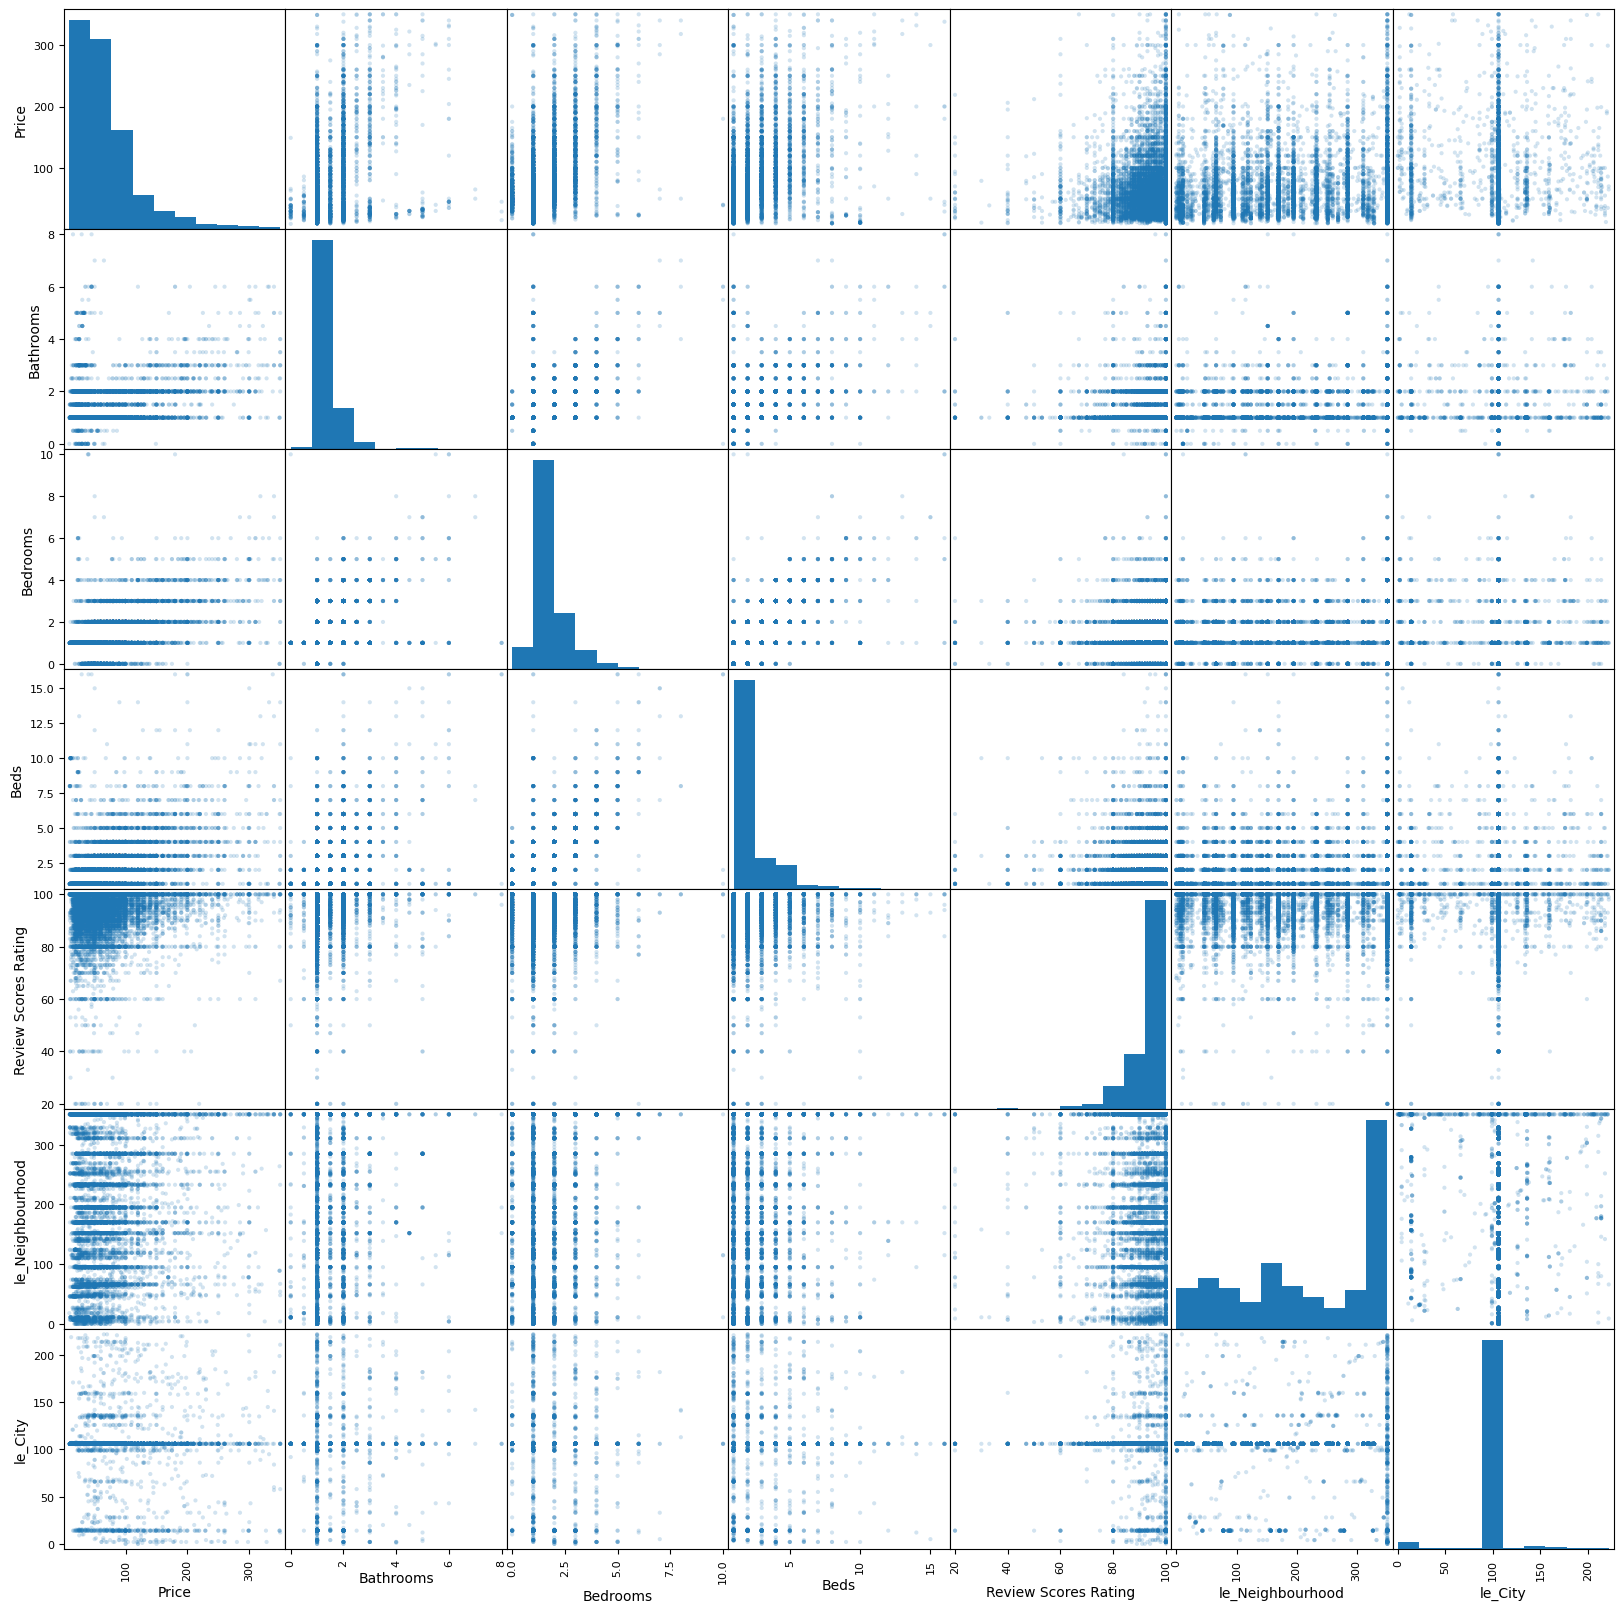

In [27]:
pd.plotting.scatter_matrix(train_data, alpha=0.2, figsize=(20, 20), diagonal = 'hist')
plt.show()

En general se puede concluir que no existe relación entre las variables que componen el problema, lo cual nos indica en principio que la elección de variables es prometedora, es decir al menos hemos elegido variables que no se superponen.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END ............................alpha=1.438449888287663; total time=   0.0s
[CV] END .............................alpha=5.45559478116852; total time=   0.0s
[CV] END .............................alpha=5.45559478116852; total time=   0.0s
[CV] END .............................alpha=5.45

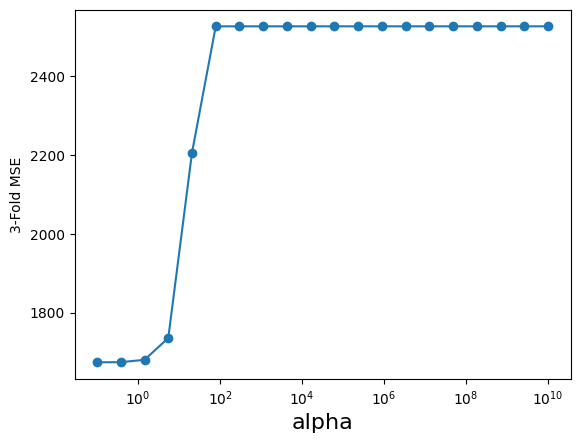

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1,10,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 3, verbose=2)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('3-Fold MSE')
plt.show()

El resultado anterior es el mismo que en el primer modelo al respecto del _alfa_ optimo lo cual indica que este modelo no promete ser mejor que el anterior. Sin embargo seguiremos hasta el final realizando Lasso con el valor optimo de _alfa_.

In [26]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = train_data.columns[1:] # es igual en train y en test

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 1.67e+03
MSE Modelo Lasso (test) : 3.91e+03
RMSE Modelo Lasso (train): 40.9
RMSE Modelo Lasso (test) : 62.5
Bathrooms 5.052221079182282
Bedrooms 17.138867744077473
Beds 10.823591486918904
Review Scores Rating 3.1943739853564024
le_Neighbourhood -0.474223341867247
le_City -2.962392022962515


Con este resultado podemos decir que Lasso no ha podido identificar variables a ser ignoradas pero aún hay algunas con valores negativos como le_Neighbourhood y le_City.

Ahora compararemos los errores del modelo anterior contra este nuevo modelo:

| Error | Primer modelo | Modelo nuevo |
| --- | --- | --- |
| MSE Modelo Lasso (train) | 2.67e+03 | 1.67e+03 |
| MSE Modelo Lasso (test) | 5.83e+03 | 3.91e+03 |
| RMSE Modelo Lasso (train) | 51.7 | 40.9 |
| RMSE Modelo Lasso (test) | 76.3 | 62.5 |

Finalmente podremos dar una respuesta a nuestra pregunta de la hipotesis inicial. La respuesta es afirmativa, es decir hemos podido construir un modelo alternativo que si bien no es excelente al menos mejora los errores reportados en el modelo anterior.